In [ ]:
!nvidia-smi

Fri May 17 16:47:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import numpy as np

In [ ]:
X = np.load('X.npy')
y = np.load('y.npy')


In [ ]:

print(X.shape)

(6705, 60, 80, 3)


In [ ]:
print(y.shape)

(6705,)


In [ ]:
import matplotlib.pyplot as plt

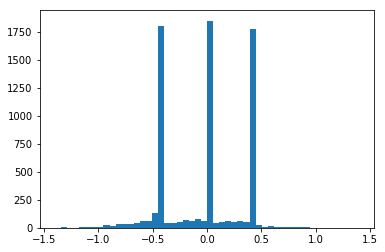

In [ ]:
plt.hist(y,50);


In [ ]:
!pip install imgaug
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
from sklearn.model_selection import train_test_split
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda 

Using TensorFlow backend.


0.0


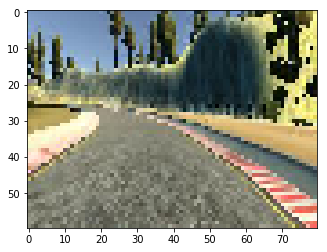

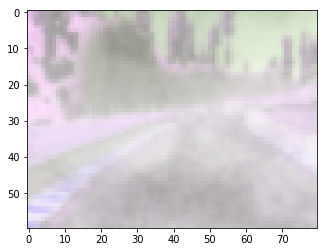

In [ ]:
def augment(img, steering_angle):
  # Flip
  if random.random() > 0.5:
    img = img[:, ::-1, :]
    steering_angle = -steering_angle
  # Blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
  img = blurer.augment_image(img)
  # Schuffle
  sh = iaa.ChannelShuffle(p=0.5)
  img = sh.augment_image(img)
  # Fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  #translate
  tx = random.randint(-20,20)
  translater = iaa.Affine(translate_px={'x':tx}, mode = 'edge')
  steering_angle -= tx*0.02   
  return img, steering_angle

plt.imshow(X[0])
print(y[0])
plt.show();

img, angle = augment(X[0], y[0])
plt.imshow(img)
plt.show();

In [ ]:
X_train, X_val,y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(5364, 60, 80, 3) (5364,)
(1341, 60, 80, 3) (1341,)


In [ ]:
Xgen = []
ygen = []

for i in range(1000): 
  img,angle = augment(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

(1000, 60, 80, 3) (1000,)


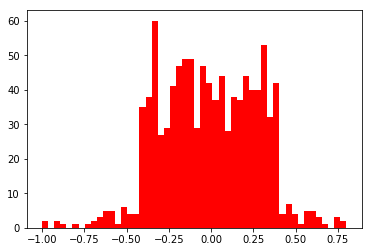

In [ ]:
#plt.hist(y,50, facecolor = 'green');
plt.hist(ygen,50, facecolor = 'red');

In [ ]:
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape, name='normalize'),
      Conv2D(64,(3,3), activation='relu'),
      Conv2D(32,(3,3), activation='relu'),
      MaxPooling2D(pool_size=(3,3)),
      Conv2D(16,(3,3), activation='relu'),
      Conv2D(8,(3,3), activation='relu'),
      Dropout(rate=0.5),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(16, activation='relu'),
      Dense(1)
  ])
  return model
model = myModel(X[0].shape)
model.summary()
model.compile('adam', 'mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 23, 16)        4624      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 21, 8)         1160      
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 21, 8)         0         
__________

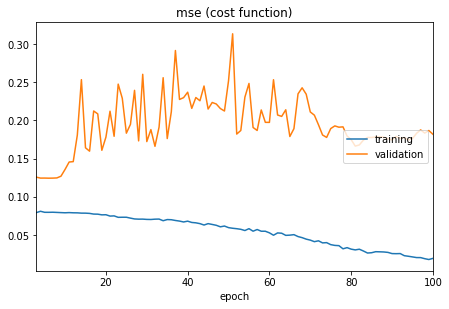

mse (cost function):
training   (min:    0.018, max:    0.081, cur:    0.019)
validation (min:    0.124, max:    0.313, cur:    0.182)


In [ ]:
batch_size = 512
epochs = 100

model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs = epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesKeras()])

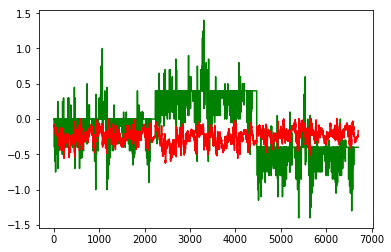

In [ ]:
ypred = model.predict(X)
plt.plot(y,'g',ypred,'r')
plt.show()

In [ ]:
model.save('mymodel1.h5')